<a href="https://colab.research.google.com/github/diecilyngonzales/DSP-LAB/blob/main/ADJA_Midterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.optimize import curve_fit
from sqlalchemy import create_engine, text

In [2]:
df = pd.read_csv('https://data.cityofchicago.org/api/views/spqx-js37/rows.csv?accessType=DOWNLOAD')
df.head()

,INTERSECTION,CAMERA ID,ADDRESS,VIOLATION DATE,VIOLATIONS,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION
0,IRVING PARK AND KILPATRICK,2763.0,4700 W IRVING PARK ROA,04/09/2015,4,NaN,NaN,NaN,NaN,NaN
1,VAN BUREN AND WESTERN,2054.0,2400 W VAN BUREN STREE,04/14/2015,5,NaN,NaN,NaN,NaN,NaN
2,115TH AND HALSTED,2552.0,11500 S HALSTED STREE,04/08/2015,5,NaN,NaN,NaN,NaN,NaN
3,IRVING PARK AND KILPATRICK,2764.0,4700 W IRVING PARK ROA,04/19/2015,4,NaN,NaN,NaN,NaN,NaN
4,ELSTON AND IRVING PARK,1503.0,3700 W IRVING PARK ROA,04/23/2015,3,NaN,NaN,NaN,NaN,NaN


In [3]:
df.shape

(892193, 10)

In [4]:
with create_engine("sqlite:///traffic.db").connect() as conn:
    conn.execute(
        text(
            """
              CREATE TABLE IF NOT EXISTS traffic_violation
              (
                INTERSECTION TEXT,
                `CAMERA ID` INT,
                ADDRESS TEXT,
                `VIOLATION DATE` DATE,
                VIOLATIONS INT,
                `X COORDINATE` DECIMAL,
                `Y COORDINATE` DECIMAL,
                LATITUDE DECIMAL,
                LONGITUDE DECIMAL,
                LOCATION TEXT
              );
            """
        )
    )
    df.to_sql(name='traffic_violation', con=conn, if_exists='append', index=False)
    display(pd.read_sql(text('SELECT * FROM traffic_violation'), conn).head())
    conn.commit()

,INTERSECTION,CAMERA ID,ADDRESS,VIOLATION DATE,VIOLATIONS,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION
0,IRVING PARK AND KILPATRICK,2763.0,4700 W IRVING PARK ROA,04/09/2015,4,NaN,NaN,NaN,NaN,None
1,VAN BUREN AND WESTERN,2054.0,2400 W VAN BUREN STREE,04/14/2015,5,NaN,NaN,NaN,NaN,None
2,115TH AND HALSTED,2552.0,11500 S HALSTED STREE,04/08/2015,5,NaN,NaN,NaN,NaN,None
3,IRVING PARK AND KILPATRICK,2764.0,4700 W IRVING PARK ROA,04/19/2015,4,NaN,NaN,NaN,NaN,None
4,ELSTON AND IRVING PARK,1503.0,3700 W IRVING PARK ROA,04/23/2015,3,NaN,NaN,NaN,NaN,None


Date Trend

Violations recorded for all cameras overtime.

In [5]:
with create_engine('sqlite:///traffic.db').connect() as conn:
    date_df = pd.read_sql(
        text(
            """
            SELECT
                "VIOLATION DATE",
                SUM(VIOLATIONS) AS VIOLATION_PER_DATE
            FROM
                traffic_violation
            GROUP BY
                "VIOLATION DATE"
            ORDER BY
                "VIOLATION DATE" ASC
            """
        )
    , conn)
date_df['VIOLATION DATE'] = pd.to_datetime(date_df['VIOLATION DATE'], format='%m/%d/%Y')
date_df = date_df.sort_values(by='VIOLATION DATE').reset_index(drop=True)
display(date_df)

,VIOLATION DATE,VIOLATION_PER_DATE
0,2014-07-01,1677
1,2014-07-02,1637
2,2014-07-03,2026
3,2014-07-04,1958
4,2014-07-05,1880
...,...,...
3386,2023-10-08,1893
3387,2023-10-09,1818
3388,2023-10-10,1925
3389,2023-10-11,1968


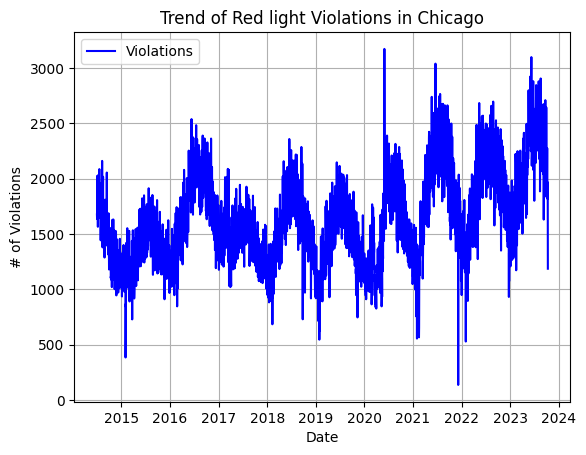

In [6]:
def plot_trend():
    """
    Plot for the trend for date.
    """
    plt.plot(date_df['VIOLATION DATE'],
             date_df['VIOLATION_PER_DATE'],
             color='b', label='Violations')
    plt.legend()
    plt.grid(True)
    plt.xlabel('Date')
    plt.ylabel('# of Violations')
    plt.title('Trend of Red light Violations in Chicago')
    plt.show()
plot_trend()

In [ ]:
def get_central_tendencies():
    """Get the central tendencies for violation."""
    viol_df = date_df.copy()
    describe_df = viol_df[['VIOLATION DATE', 'VIOLATION_PER_DATE']].describe()
    years = viol_df['VIOLATION DATE'].dt.year.unique()
    for i in viol_df['VIOLATION DATE'].dt.year.unique():
      describe_df[f'VIOLATION IN {i}'] = viol_df[
          viol_df['VIOLATION DATE'].dt.year == i].describe().values
    for i in viol_df['VIOLATION DATE'].dt.month_name().unique():
      describe_df[f'VIOLATION IN {i}'] = viol_df[
          viol_df['VIOLATION DATE'].dt.month_name() == i].describe().values
    return describe_df.transpose()
get_central_tendencies()

,count,mean,std,min,25%,50%,75%,max
VIOLATION_PER_DATE,3391.0,1630.831023,407.080025,137.0,1321.00,1584.0,1908.50,3173.0
VIOLATION IN 2014,184.0,1451.429348,275.356650,946.0,1228.00,1407.0,1677.75,2161.0
VIOLATION IN 2015,365.0,1328.142466,221.949953,385.0,1176.00,1318.0,1467.00,1914.0
VIOLATION IN 2016,366.0,1738.928962,340.507985,847.0,1484.25,1775.0,1988.00,2539.0
VIOLATION IN 2017,365.0,1441.747945,213.511953,1007.0,1286.00,1419.0,1595.00,2089.0
VIOLATION IN 2018,365.0,1542.238356,319.734773,685.0,1318.00,1565.0,1765.00,2359.0
VIOLATION IN 2019,365.0,1452.063014,291.423560,546.0,1255.00,1447.0,1675.00,2148.0
VIOLATION IN 2020,366.0,1531.748634,385.772809,827.0,1217.00,1493.0,1816.25,3173.0
VIOLATION IN 2021,365.0,1854.189041,452.222922,137.0,1552.00,1893.0,2161.00,3040.0
VIOLATION IN 2022,365.0,1872.301370,369.433591,529.0,1611.00,1898.0,2135.00,2697.0
